
# Model of "RAELLA: Reforming the Arithmetic for Efficient, Low-Resolution, and
Low-Loss Analog PIM: No Retraining Required!", ISCA 2023
--------------------------------------------------------------------------------

Paper by Tanner Andrulis, Joel S. Emer, Vivienne Sze

RAELLA is a ReRAM-based analog CiM accelerator that enables low-energy
high-accuracy analog-domain computation. To enable high accuracy, it uses
several slicing and encoding strategies to enable high-fidelity full-precision
arithmetic.

Some of the important variables for raella_isca_2023:

- *ARRAY_WORDLINES*: 512 rows in the array
- *ARRAY_BITLINES*: 1024 columns in the array
- *ARRAY_PARALLEL_INPUTS*: 512 input slice(s) consumed in each cycle.
- *ARRAY_PARALLEL_WEIGHTS*: 262144 weights slice(s) used for computation in each cycle.
- *ARRAY_PARALLEL_OUTPUTS*: 512 output(s) produced in each cycle.
- *TECHNOLOGY*: 32 nm
- *ADC_RESOLUTION*: 7 bit(s)
- *DAC_RESOLUTION*: 1 bit(s)
- *N_ADC_PER_BANK*: 4 ADC(s)
- *SUPPORTED_INPUT_BITS*: 8 bit(s)
- *SUPPORTED_OUTPUT_BITS*: 8 bit(s)
- *SUPPORTED_WEIGHT_BITS*: 8 bit(s)
- *BITS_PER_CELL*: 3 bit(s)
- *CIM_UNIT_WIDTH_CELLS*: 2 adjacent cell(s) in a wordline store bit(s) in one weight slice and process one input & output slice together
- *CIM_UNIT_DEPTH_CELLS*: 1 adjacent cell(s) in a bitline operate in separate cycles
- *CELL_CONFIG*: /home/tanner/research/cimloop/cimloop/workspace/models/memory_cells/rram_raella_isca_2023.cell.yaml 
- *GLOBAL_CYCLE_SECONDS*: 1e-09 clock period

### Tile Level

Eight macros are organized into a tile. Each tile includes a 64kB eDRAM buffer
storing 8b inputs/outputs, digital maxpool units, and quantization circuits.
RAELLA digitally computes 8b per-channel quantization, allocating 32b per output
channel to store a FP16 quantization scale and bias, or 32kB per tile.


- *Input Path*: Inputs are stored in the eDRAM. An inter-macro network sends
  inputs to macros in the tile.
- *Weight Path*: Weights are kept static in inference and do not move through
  this level.
- *Output Path*: Outputs are gathered from macros via the inter-tile network.
  They are quantized to 8b before being written to the eDRAM.

Next, there are 8 macros in each tile. Inputs and outputs can be spatially
reused across macros with a multicast/reduction network.

### Macro Level

Four arrays are organized into a macro with an input buffer. An input network
sends input vectors to arrays, and if all inputs are shared between two arrays,
the input vector is multicast. To exploit temporal input reuse, the input buffer
stores reused inputs between array cycles. The four arrays can process up to 4×
512 = 2048 inputs across all rows, so the buffer is sized 2kB. To support
Center+Offset weights, each macro includes a weight center buffer and digital
addition circuitry to calculate input sums. A running sum is kept for each
array. To exploit input reuse, we add inputs to the sum when they are first used
in array columns and subtract when they are last used. If different array
columns use different subsets of the inputs, RAELLA adds/subtracts inputs in a
streaming fashion while processing columns.

- *Input Path*: Inputs are stored in the input buffer. The input buffer includes
  circuitry to maintain a running sum of inputs for Center+Offset encoding.
- *Weight Path*: Weights are kept static in inference and do not move through
  this level.
- *Output Path*: Outputs pass through a Center+Offset correction circuit that
  uses the input running sum to calculate the final output.
  
Next, there are 4 arrays in each macro. Inputs and outputs can be spatially
reused across arrays with a multicast/reduction network.

### Array Level

Arrays consist of 512 × 512 2T2Rs. Each array is programmed with weights from
one DNN layer, and each weight filter uses 2-8 array columns based on the DNN
layer slicing. 4-bit pulse-train DACs encode inputs, and 7-bit ADCs convert
outputs from each column.

7b signed ADC results are summed by shift+add circuits and accumulated in 16b
output buffers. With the most-dense slicing of two slices per weight, one array
may produce up to 256 outputs, which are stored in a 256-entry output buffer.
Each entry stores a 16b output + 8b success flags, for a 768B output buffer
total capacity.

RAELLA supports speculation, where it runs the array with a 2-4b input slice,
records which columns saturate, and then reprocesses only the failed columns
using 2-4 1b input slices. RAELLA also supports recovery-only, where it runs 1b
input slices only, processing all columns for these slices. Speculation saves
energy by reducing the number of ADC conversions, but it increases latency due
to the added cycles.

In speculation/recovery cycles, inputs are streamed to arrays once for each
cycle. In speculation, ADCs process all columns. If an ADC saturates, the output
is not updated and the success flag is marked. In recovery, all success flags
are checked. ADCs process and write results only for columns that failed
speculation. 

If inputs are signed, RAELLA processes positive/negative inputs in two separate
cycles.

- *Input Path*: Inputs pass through a 4-bit DACs and appear on the rows of the
  array.
- *Weight Path*: Weights are stored in the array and are not moved during
  inference.
- *Output Path*: Outputs are read from the columns of the array with 7-bit ADCs.
  They are shifted+added before being stored in a psum register. The psum
  register also stores speculation success flags.

Next, there are 512 columns in each array. Inputs are reused between columns
(*i.e.,* each input-carrying wire connects to all columns), while outputs and
weights are not reused.

### Column Level

Each column consists of 512 2T2Rs ReRAM devices. Depending on how RAELLA slices
weights, columns may store 1b-4b weight slices (2-8 slices per weight value).

- *Input Path*: Each input is passed directly to a row in the column.
- *Weight Path*: Weights are not moved during inference.
- *Output Path*: Outputs pass through a current mirror to buffer their values
  before exiting the column.
  
### Row Level

Each row in a column has one 2T2R device which stores a differentially-encoded
weight value.

- *Input Path*: The input is used for a MAC operation.
- *Weight Path*: A 2-4b weight is stored in the 2T2R device and is used for a
  MAC operation.
- *Output Path*: The output is supplied by a MAC operation.

                 


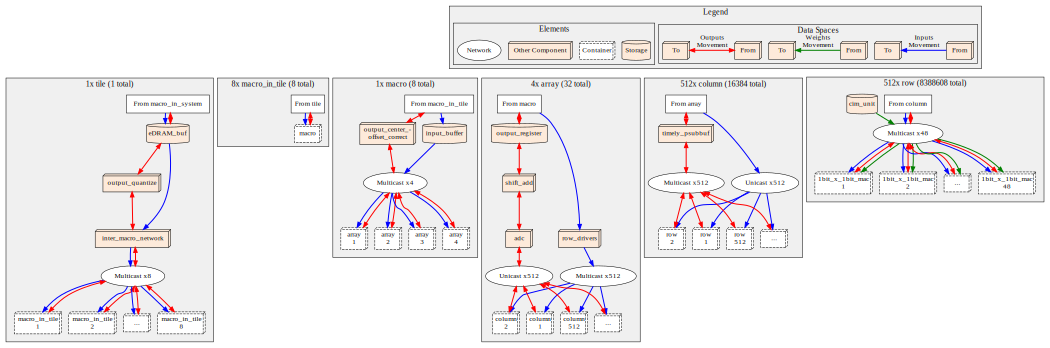

In [2]:
from _tests import scripts
from scripts.notebook_utils import *

display_markdown(f"""
# Model of "RAELLA: Reforming the Arithmetic for Efficient, Low-Resolution, and
Low-Loss Analog PIM: No Retraining Required!", ISCA 2023
--------------------------------------------------------------------------------

Paper by Tanner Andrulis, Joel S. Emer, Vivienne Sze

RAELLA is a ReRAM-based analog CiM accelerator that enables low-energy
high-accuracy analog-domain computation. To enable high accuracy, it uses
several slicing and encoding strategies to enable high-fidelity full-precision
arithmetic.

{get_important_variables_markdown('raella_isca_2023')}

### Tile Level

Eight macros are organized into a tile. Each tile includes a 64kB eDRAM buffer
storing 8b inputs/outputs, digital maxpool units, and quantization circuits.
RAELLA digitally computes 8b per-channel quantization, allocating 32b per output
channel to store a FP16 quantization scale and bias, or 32kB per tile.


- *Input Path*: Inputs are stored in the eDRAM. An inter-macro network sends
  inputs to macros in the tile.
- *Weight Path*: Weights are kept static in inference and do not move through
  this level.
- *Output Path*: Outputs are gathered from macros via the inter-tile network.
  They are quantized to 8b before being written to the eDRAM.

Next, there are 8 macros in each tile. Inputs and outputs can be spatially
reused across macros with a multicast/reduction network.

### Macro Level

Four arrays are organized into a macro with an input buffer. An input network
sends input vectors to arrays, and if all inputs are shared between two arrays,
the input vector is multicast. To exploit temporal input reuse, the input buffer
stores reused inputs between array cycles. The four arrays can process up to 4×
512 = 2048 inputs across all rows, so the buffer is sized 2kB. To support
Center+Offset weights, each macro includes a weight center buffer and digital
addition circuitry to calculate input sums. A running sum is kept for each
array. To exploit input reuse, we add inputs to the sum when they are first used
in array columns and subtract when they are last used. If different array
columns use different subsets of the inputs, RAELLA adds/subtracts inputs in a
streaming fashion while processing columns.

- *Input Path*: Inputs are stored in the input buffer. The input buffer includes
  circuitry to maintain a running sum of inputs for Center+Offset encoding.
- *Weight Path*: Weights are kept static in inference and do not move through
  this level.
- *Output Path*: Outputs pass through a Center+Offset correction circuit that
  uses the input running sum to calculate the final output.
  
Next, there are 4 arrays in each macro. Inputs and outputs can be spatially
reused across arrays with a multicast/reduction network.

### Array Level

Arrays consist of 512 × 512 2T2Rs. Each array is programmed with weights from
one DNN layer, and each weight filter uses 2-8 array columns based on the DNN
layer slicing. 4-bit pulse-train DACs encode inputs, and 7-bit ADCs convert
outputs from each column.

7b signed ADC results are summed by shift+add circuits and accumulated in 16b
output buffers. With the most-dense slicing of two slices per weight, one array
may produce up to 256 outputs, which are stored in a 256-entry output buffer.
Each entry stores a 16b output + 8b success flags, for a 768B output buffer
total capacity.

RAELLA supports speculation, where it runs the array with a 2-4b input slice,
records which columns saturate, and then reprocesses only the failed columns
using 2-4 1b input slices. RAELLA also supports recovery-only, where it runs 1b
input slices only, processing all columns for these slices. Speculation saves
energy by reducing the number of ADC conversions, but it increases latency due
to the added cycles.

In speculation/recovery cycles, inputs are streamed to arrays once for each
cycle. In speculation, ADCs process all columns. If an ADC saturates, the output
is not updated and the success flag is marked. In recovery, all success flags
are checked. ADCs process and write results only for columns that failed
speculation. 

If inputs are signed, RAELLA processes positive/negative inputs in two separate
cycles.

- *Input Path*: Inputs pass through a 4-bit DACs and appear on the rows of the
  array.
- *Weight Path*: Weights are stored in the array and are not moved during
  inference.
- *Output Path*: Outputs are read from the columns of the array with 7-bit ADCs.
  They are shifted+added before being stored in a psum register. The psum
  register also stores speculation success flags.

Next, there are 512 columns in each array. Inputs are reused between columns
(*i.e.,* each input-carrying wire connects to all columns), while outputs and
weights are not reused.

### Column Level

Each column consists of 512 2T2Rs ReRAM devices. Depending on how RAELLA slices
weights, columns may store 1b-4b weight slices (2-8 slices per weight value).

- *Input Path*: Each input is passed directly to a row in the column.
- *Weight Path*: Weights are not moved during inference.
- *Output Path*: Outputs pass through a current mirror to buffer their values
  before exiting the column.
  
### Row Level

Each row in a column has one 2T2R device which stores a differentially-encoded
weight value.

- *Input Path*: The input is used for a MAC operation.
- *Weight Path*: A 2-4b weight is stored in the 2T2R device and is used for a
  MAC operation.
- *Output Path*: The output is supplied by a MAC operation.

                 
""")
display_diagram(get_diagram("raella_isca_2023", ignore=DIAGRAM_DEFAULT_IGNORE, tile="raella"))


   This test explores the energy, area, and latency of the accelerator
   computing MVM operations with and without speculation.

   We find that speculation increases array and DAC energy due to speculation
   cycles. Increases the input buffer energy due to 2× fetches of inputs (for
   speculation & recovery cycles). It decreases output buffer energy and ADC
   energy due to fewer analog outputs being read from the array and written to
   the output buffer.
   

100%|██████████| 2/2 [00:03<00:00,  1.77s/it]


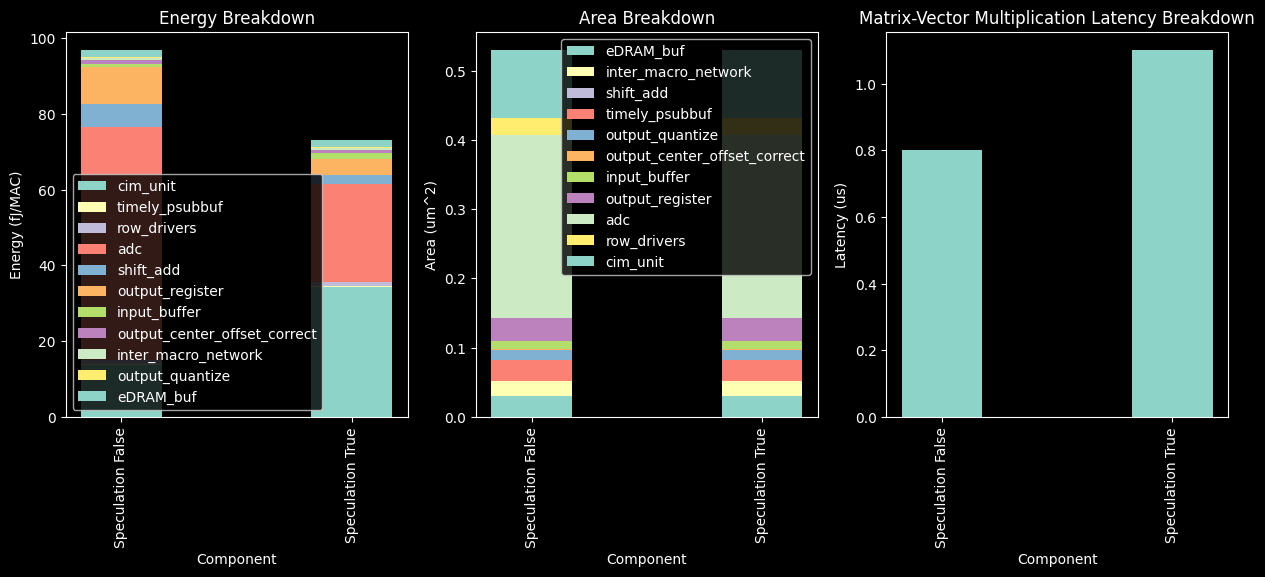

In [3]:
result = run_test("raella_isca_2023", "test_energy_breakdown")
n_subplots = len(result)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
bar_stacked(
    {f"Speculation {r.variables['SPECULATION_ENABLED']}": r.per_compute('per_component_energy')*1e15 for r in result},
    ylabel="Energy (fJ/MAC)",
    title=f"Energy Breakdown",
    ax=axs[0]
)
bar_stacked(
    {f"Speculation {r.variables['SPECULATION_ENABLED']}": r.per_compute('per_component_area')*1e12 for r in result},
    ylabel="Area (um^2)",
    title=f"Area Breakdown",
    ax=axs[1]
)

# Latency
bar_stacked(
    {f"Speculation {r.variables['SPECULATION_ENABLED']}": {"": r.latency*1e6} for r in result},
    ylabel="Latency (us)",
    title=f"Matrix-Vector Multiplication Latency Breakdown",
    ax=axs[2]
)

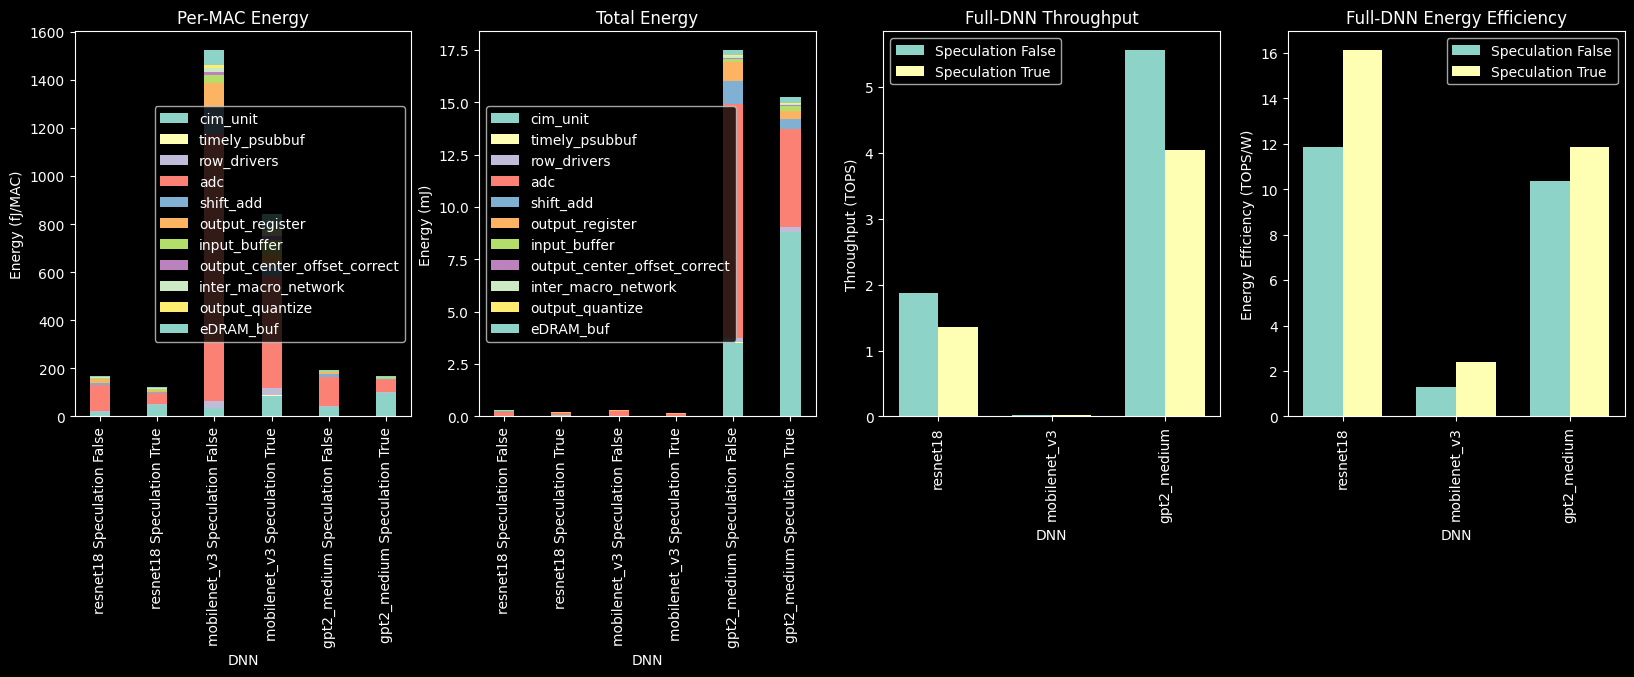

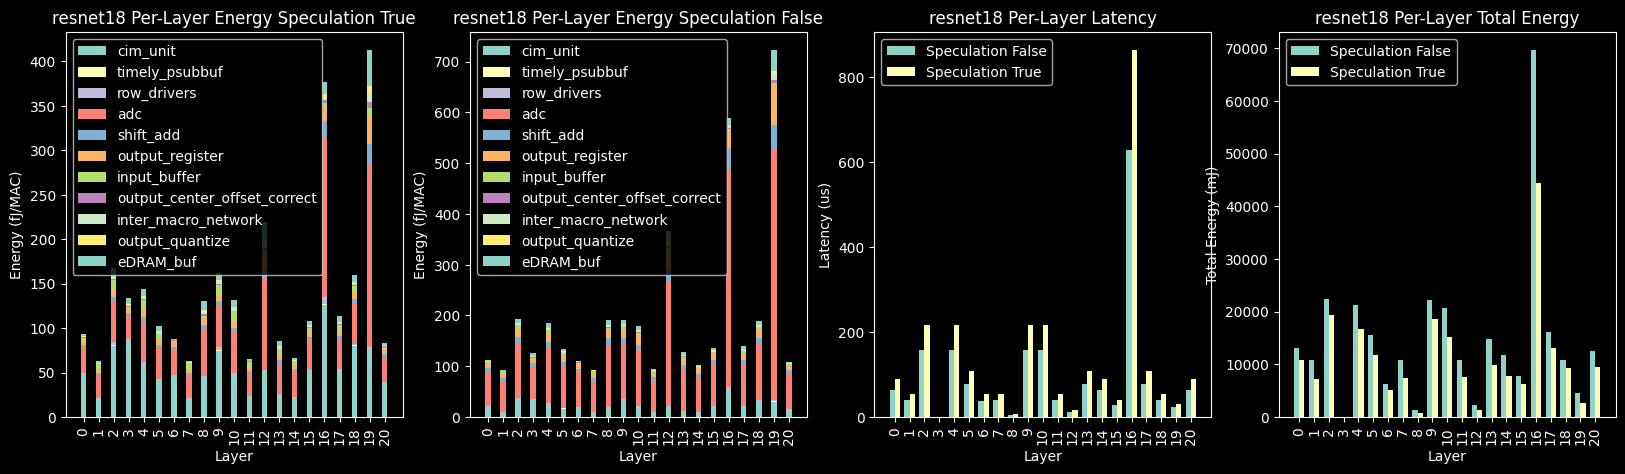

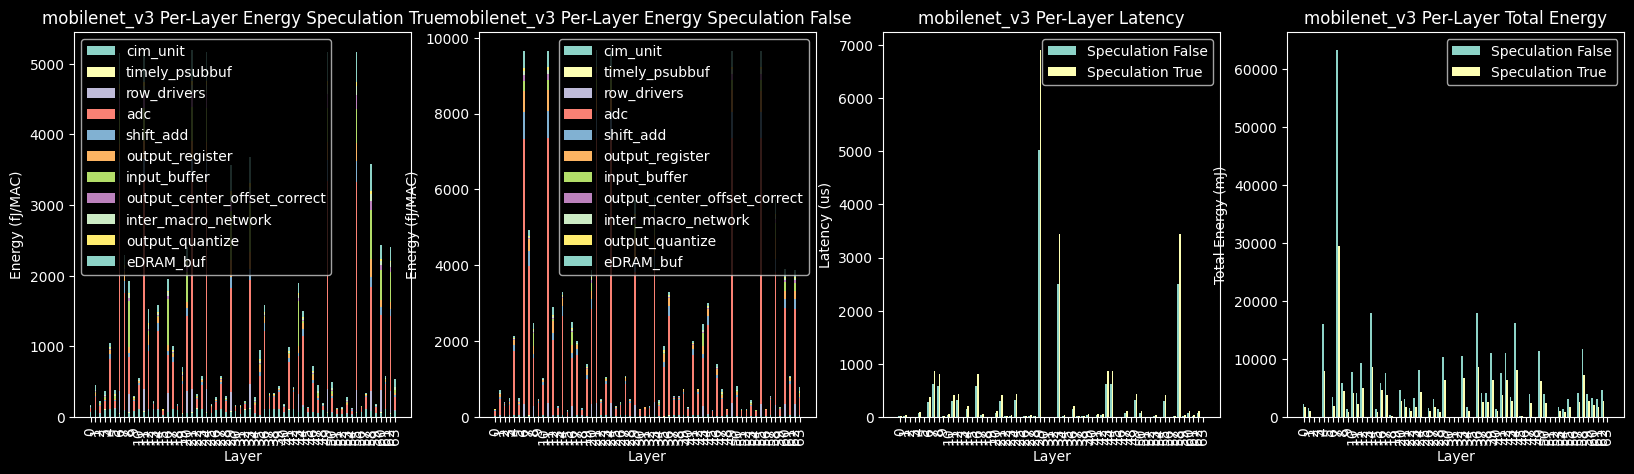

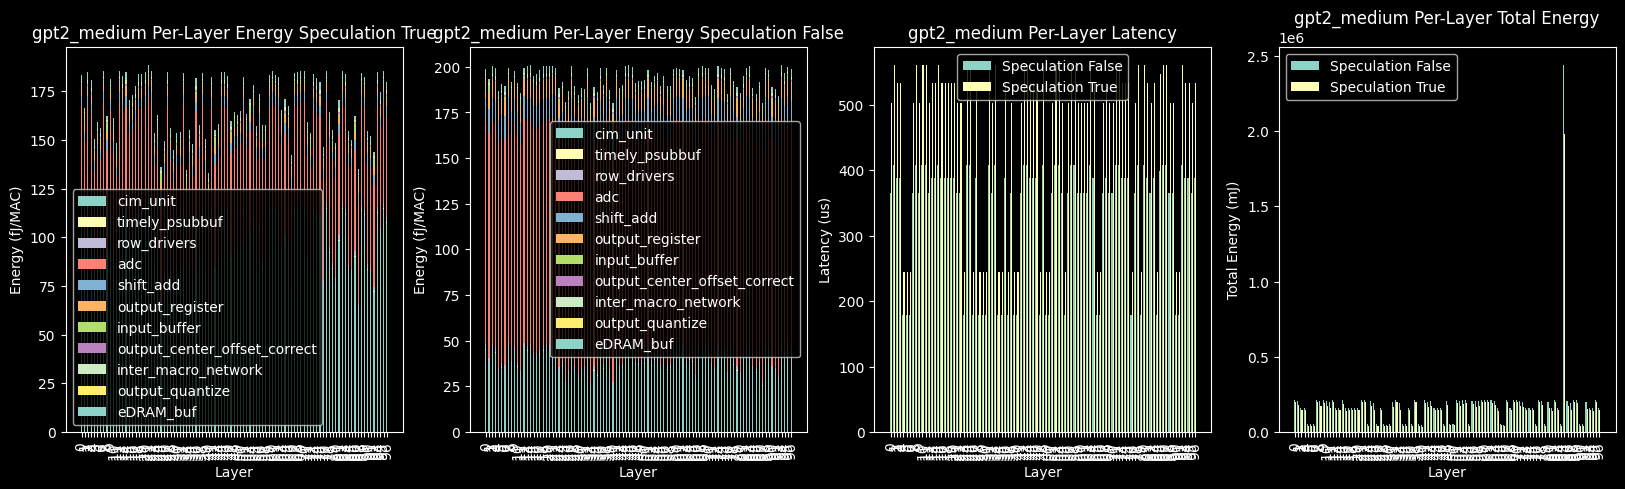

In [9]:
# This test may take a while to run. We have to find a mapping for every layer
# for every DNN being tested.
# results = {}
# for i, dnn in enumerate(["resnet18", "mobilenet_v3", "gpt2_medium"]):
#     results[dnn] = run_test(
#         "raella_isca_2023", "test_full_dnn", dnn_name=dnn, show_doc=i == 0
#     )

# Full-DNN results

fig, axs = plt.subplots(1, 4, figsize=(20, 5))


consolidated = {
    f'{dnn} Speculation {r.variables["SPECULATION_ENABLED"]}': r 
    for dnn, result in results.items() 
    for r in result.aggregate_by("SPECULATION_ENABLED")
}
bar_stacked( # Per-MAC Energy
    {k: r.per_compute('per_component_energy')*1e15 for k, r in consolidated.items()},
    xlabel="DNN",
    ylabel="Energy (fJ/MAC)",
    title="Per-MAC Energy",
    ax=axs[0],
)
bar_stacked( # Total Energy
    {k: r.per_component_energy*1e3 for k, r in consolidated.items()},
    xlabel="DNN",
    ylabel="Energy (mJ)",
    title="Total Energy",
    ax=axs[1],
)

tops, tops_per_w = {}, {}
for dnn, r in results.items():
    tops[dnn], tops_per_w[dnn] = {}, {}
    for r2 in r.aggregate_by("SPECULATION_ENABLED"):
        speculation = f'Speculation {r2.variables["SPECULATION_ENABLED"]}'
        tops[dnn][speculation] = r2.tops
        tops_per_w[dnn][speculation] = r2.tops_per_w

for ax, data, title, ylabel in [
    (axs[2], tops, "Throughput", "TOPS"),
    (axs[3], tops_per_w, "Energy Efficiency", "TOPS/W"),
]:
    bar_side_by_side(
        data,
        xlabel="DNN",
        ylabel=f"{title} ({ylabel})",
        title=f"Full-DNN {title}",
        ax=ax,
    )

# Per-Layer Results
for dnn, result in results.items():
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    # First graph: Per-layer per-component energy for speculation = TRUE
    # Second graph: Per-layer per-component energy for speculation = FALSE
    for a, speculation_enabled in zip(ax, [True, False]):
        per_layer_results = {}
        bar_stacked(
            {i: r.per_compute('per_component_energy')*1e15 for i, r in enumerate(result.split_by("SPECULATION_ENABLED")[speculation_enabled])},
            xlabel="Layer",
            ylabel="Energy (fJ/MAC)",
            title=f"{dnn} Per-Layer Energy Speculation {speculation_enabled}",
            ax=a,
        )
    
    for ax, attrname, title, ylabel, scaleby in [
        (ax[2], "latency", "Latency", "us", 1e6),
        (ax[3], "energy", "Total Energy", "mJ", 1e9),
    ]:
        per_layer_results = {}
        for j, same_layers in enumerate(zip(*result.split_by("SPECULATION_ENABLED"))):
            per_layer_results[j] = {
                f'Speculation {r.variables["SPECULATION_ENABLED"]}': getattr(r, attrname) * scaleby
                for r in same_layers
            }
        bar_side_by_side(
            per_layer_results,
            xlabel="Layer",
            ylabel=f"{title} ({ylabel})",
            title=f"{dnn} Per-Layer {title}",
            ax=ax,
        )
        